In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import (
    roc_auc_score,
    precision_recall_curve,
    auc,
    confusion_matrix,
    ConfusionMatrixDisplay,
    f1_score,
    precision_score,
    recall_score,
    accuracy_score,
    roc_curve,
)
import shap
from transformers import pipeline
import torch


if torch.cuda.is_available():
    print("CUDA is available. Using GPU.")
    device = 0
else:
    print("CUDA not available. Falling back to CPU.")
    device = -1

import json
import warnings

sns.set_style("darkgrid")
warnings.filterwarnings("ignore")

/home/reynald/RLDatix_assignment/venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CUDA is available. Using GPU.


# Predictive Modelling (Binary Classification)

## Exploratory data analysis

In [2]:
df = pd.read_excel("Assignment_Data.xlsx")

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 9 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   patient_id               200 non-null    int64 
 1   age                      200 non-null    int64 
 2   gender                   200 non-null    object
 3   diagnosis_code           200 non-null    object
 4   num_previous_admissions  200 non-null    int64 
 5   medication_type          200 non-null    object
 6   length_of_stay           200 non-null    int64 
 7   readmitted_30_days       200 non-null    int64 
 8   discharge_note           200 non-null    object
dtypes: int64(5), object(4)
memory usage: 14.2+ KB


In [4]:
df.head()

,patient_id,age,gender,diagnosis_code,num_previous_admissions,medication_type,length_of_stay,readmitted_30_days,discharge_note
0,1,71,Male,D002,3,Type C,2,0,Good recovery trajectory. Follow-up scan sched...
1,2,34,Female,D002,1,Type B,3,1,Stable post-surgery. Advised to avoid physical...
2,3,80,Male,D002,2,Type C,5,1,Symptoms controlled. Monitoring for relapse ad...
3,4,40,Female,D002,2,Type C,11,0,Stable post-surgery. Advised to avoid physical...
4,5,43,Female,D001,1,Type C,8,1,Stable post-surgery. Advised to avoid physical...


In [5]:
df.describe()

,patient_id,age,num_previous_admissions,length_of_stay,readmitted_30_days
count,200.000000,200.000000,200.000000,200.000000,200.00000
mean,100.500000,53.720000,1.600000,7.865000,0.32500
std,57.879185,21.294574,1.310951,4.134276,0.46955
min,1.000000,20.000000,0.000000,1.000000,0.00000
25%,50.750000,34.000000,1.000000,4.000000,0.00000
50%,100.500000,54.000000,1.000000,8.000000,0.00000
75%,150.250000,73.000000,2.000000,11.000000,1.00000
max,200.000000,89.000000,6.000000,14.000000,1.00000


In [6]:
len(np.unique(df["patient_id"]))

200

In [7]:
df.describe(include="object")

,gender,diagnosis_code,medication_type,discharge_note
count,200,200,200,200
unique,2,4,3,10
top,Female,D001,Type B,Discharge after recovery from pneumonia. No co...
freq,107,56,69,25


In [8]:
df["gender"].value_counts()

gender
Female    107
Male       93
Name: count, dtype: int64

In [9]:
df["diagnosis_code"].value_counts()

diagnosis_code
D001    56
D002    54
D004    53
D003    37
Name: count, dtype: int64

In [10]:
df["medication_type"].value_counts()

medication_type
Type B    69
Type A    67
Type C    64
Name: count, dtype: int64

In [11]:
df["discharge_note"].value_counts()

discharge_note
Discharge after recovery from pneumonia. No complications observed.        25
Symptoms controlled. Monitoring for relapse advised.                       23
Patient discharged in stable condition. Recommend follow-up in 2 weeks.    23
Blood pressure under control. Continue current medication.                 22
Stable post-surgery. Advised to avoid physical exertion.                   19
Good recovery trajectory. Follow-up scan scheduled next month.             19
No further signs of infection. Resume normal diet and activity.            18
Patient discharged with minor discomfort. Advised rest and hydration.      18
Mild reaction to medication. Switched to alternative treatment.            17
Patient showed improvement. Prescribed antibiotics for 5 days.             16
Name: count, dtype: int64

In [12]:
df.isna().sum()

patient_id                 0
age                        0
gender                     0
diagnosis_code             0
num_previous_admissions    0
medication_type            0
length_of_stay             0
readmitted_30_days         0
discharge_note             0
dtype: int64

- The dataset contains 200 rows and 8 columns, including an ID column and a binary target variable `readmitted_30_days`.
- The dataset doesn't contain any missing values.

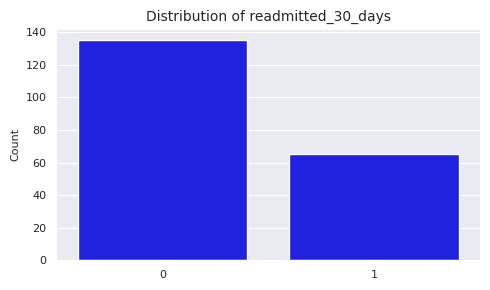

In [13]:
fig, ax = plt.subplots(figsize=(5, 3))

sns.countplot(x="readmitted_30_days", data=df, ax=ax, color="blue")
ax.set_title("Distribution of readmitted_30_days", size=10)
ax.set_xlabel("")
ax.set_ylabel("Count", size=8)
ax.tick_params(axis="both", which="major", labelsize=8)
ax.tick_params(axis="both", which="minor", labelsize=8)
ax.set_xticks([0, 1])
# ax.set_xticklabels(["No Sale", "Sale"])

plt.tight_layout()
plt.show()

In [14]:
df["readmitted_30_days"].value_counts(), df["readmitted_30_days"].value_counts(
    normalize=True
)

(readmitted_30_days
 0    135
 1     65
 Name: count, dtype: int64,
 readmitted_30_days
 0    0.675
 1    0.325
 Name: proportion, dtype: float64)

67.5% of rows are for patients who were not readmitted within 30 days.

In [15]:
numerical_cols = ["age", "num_previous_admissions", "length_of_stay"]

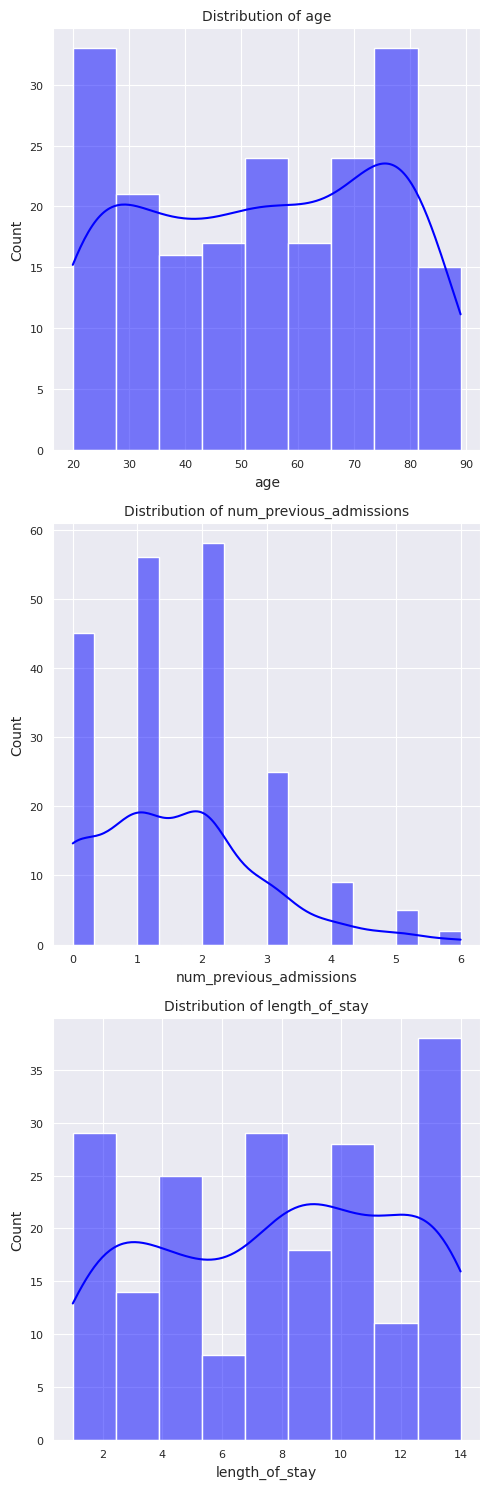

In [16]:
fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(5, 15))

for i, col in enumerate(numerical_cols):
    ax = axes[i]
    sns.histplot(df[col], kde=True, ax=ax, color="blue")
    ax.set_title(f"Distribution of {col}", size=10)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")
    ax.tick_params(axis="both", which="major", labelsize=8)
    ax.tick_params(axis="both", which="minor", labelsize=8)

for i in range(len(numerical_cols), len(axes.flat)):
    axes.flat[i].set_axis_off()

plt.tight_layout()
plt.show()

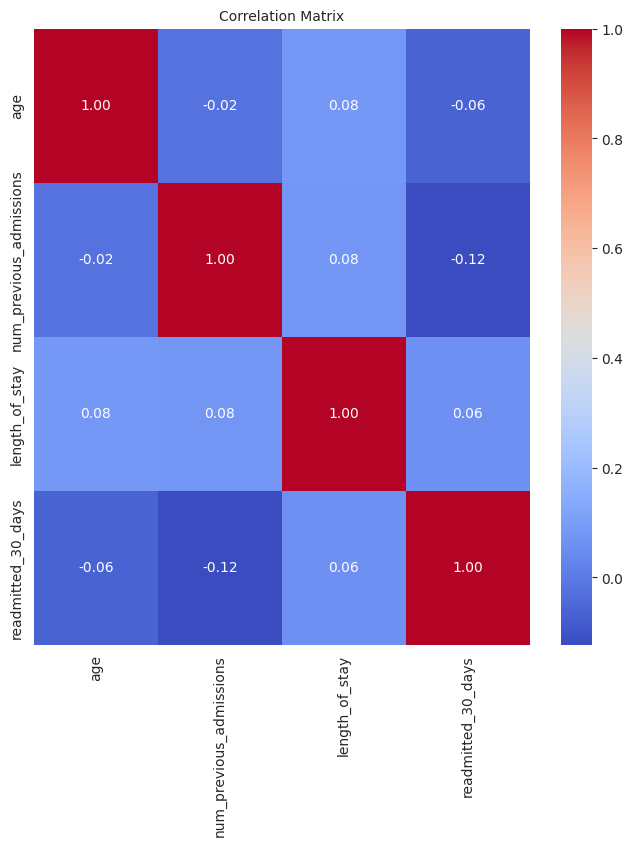

In [17]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(
    data=df[list(numerical_cols) + ["readmitted_30_days"]].corr(),
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    ax=ax,
)
ax.set_title("Correlation Matrix", size=10)

plt.show()

Small correlation between `readmitted_30_days` and `num_previous_admissions` but it's quite low still. The other variables don't seem to show much correlation together.

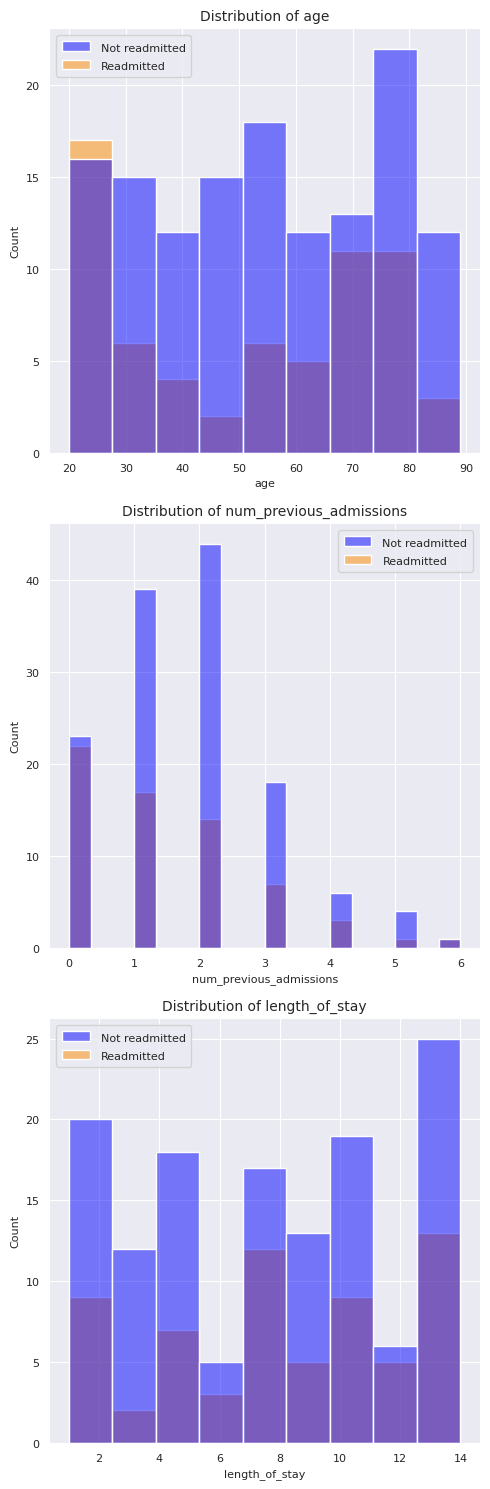

In [18]:
fig, axes = plt.subplots(len(numerical_cols), 1, figsize=(5, 15))

for i, col in enumerate(numerical_cols):
    ax = axes[i]
    sns.histplot(
        data=df, x=col, hue="readmitted_30_days", ax=ax, palette=["blue", "darkorange"]
    )
    ax.set_title(f"Distribution of {col}", size=10)
    ax.set_xlabel(col, size=8)
    ax.set_ylabel("Count", size=8)
    ax.tick_params(axis="both", which="major", labelsize=8)
    ax.tick_params(axis="both", which="minor", labelsize=8)
    ax.get_legend().set_title(None)
    ax.get_legend().get_texts()[0].set_text("Not readmitted")
    ax.get_legend().get_texts()[1].set_text("Readmitted")
    for label in ax.get_legend().get_texts():
        label.set_fontsize(8)

for i in range(len(numerical_cols), len(axes.flat)):
    axes.flat[i].set_axis_off()

plt.tight_layout()
plt.show()

- Young people seem to have a higher rate of being readmitted within 30 days than other groups. There's also a relatively high rate for individuals around 70 years old. That rate is relatively low for patients around 40-50 years old.
- There's a relatively hgih rate of readmissions for patients with no previous admissions.
- We cannot say much about the length of stay.

In [19]:
categorical_cols = ["gender", "diagnosis_code", "medication_type", "discharge_note"]

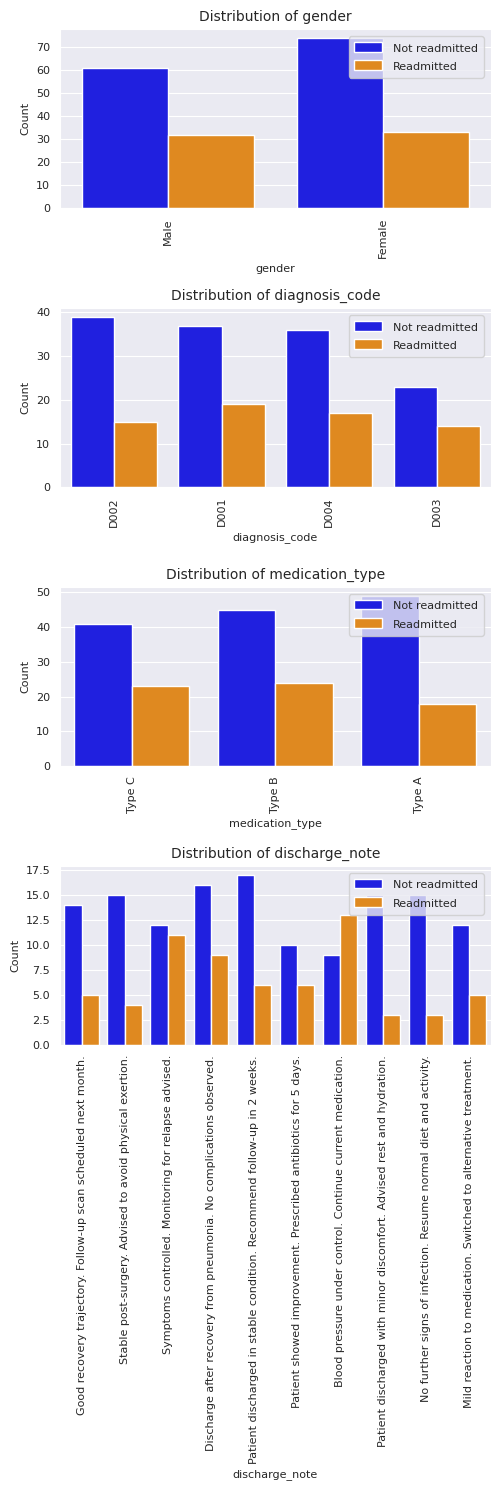

In [20]:
fig, axes = plt.subplots(len(categorical_cols), 1, figsize=(5, 15))

for i, col in enumerate(categorical_cols):
    ax = axes[i]
    sns.countplot(
        x=col,
        hue="readmitted_30_days",
        data=df,
        ax=ax,
        palette=["blue", "darkorange"],
    )
    ax.set_title(f"Distribution of {col}", size=10)
    ax.set_xlabel(f"{col}", size=8)
    ax.set_ylabel("Count", size=8)
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90)
    ax.tick_params(axis="both", which="major", labelsize=8)
    ax.tick_params(axis="both", which="minor", labelsize=8)
    ax.get_legend().set_title(None)
    ax.get_legend().get_texts()[0].set_text("Not readmitted")
    ax.get_legend().get_texts()[1].set_text("Readmitted")
    for label in ax.get_legend().get_texts():
        label.set_fontsize(8)

for i in range(len(categorical_cols), len(axes.flat)):
    axes.flat[i].set_axis_off()

plt.tight_layout()
plt.show()

- There is a small difference between males and females regarding readmission, with males having a higher chance being readmitted.
- Patients with a D003 diagnosis code are more likely being readmitted, and patients with a D002 diagnosis code are less likely being readmitted.
- Medication types seem to have an impact, with type A showing the least amount of readmissions, then type B and finally type C.
- Some discharge notes seem to indicate a higher risk of readmission, for example `Blood pressure under control. Continue current medication.` showing more readmissions than non-readmissions. However, some notes show a small rate of readmissions, particularly ones indicating to resume to normal diet, advising rest or showing stability post-surgery.

## Modeling part

- For the modeling part, we will keep all the features present in the dataset (apart from the ID).
- We will try 3 different models: logistic regression, random forest classifier and XGBoost classifier.
- We will initially split the dataset into training and test sets, with a 80/20 split. We will use the stratify strategy to keep the imbalance in the dataset.
- For categorical variables, we will transform the values using one-hot encoding.
- Only for logistic regression, numerical values will be centered and scaled to unit variance.

In [21]:
numerical_cols + categorical_cols

['age',
 'num_previous_admissions',
 'length_of_stay',
 'gender',
 'diagnosis_code',
 'medication_type',
 'discharge_note']

In [22]:
X = df[numerical_cols + categorical_cols]
y = df["readmitted_30_days"]

In [23]:
def split_dataset(X, y, random_state=0):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, stratify=y, random_state=random_state
    )

    return X_train, X_test, y_train, y_test

In [24]:
def get_lr_model():
    lr_preprocessor = ColumnTransformer(
        transformers=[
            ("numerical", StandardScaler(), numerical_cols),
            ("categorical", OneHotEncoder(drop="first"), categorical_cols),
        ]
    )
    lr_clf = LogisticRegression(random_state=0)
    lr_model = Pipeline(steps=[("preprocessor", lr_preprocessor), ("clf", lr_clf)])

    return lr_model


def get_rf_model():
    rf_preprocessor = ColumnTransformer(
        transformers=[
            ("numerical", "passthrough", numerical_cols),
            ("categorical", OneHotEncoder(), categorical_cols),
        ]
    )
    rf_clf = RandomForestClassifier(random_state=0)
    rf_model = Pipeline(steps=[("preprocessor", rf_preprocessor), ("clf", rf_clf)])

    return rf_model


def get_xgb_model():
    xgb_preprocessor = ColumnTransformer(
        transformers=[
            ("numerical", "passthrough", numerical_cols),
            ("categorical", OneHotEncoder(), categorical_cols),
        ]
    )
    xgb_clf = XGBClassifier(random_state=0)
    xgb_model = Pipeline(steps=[("preprocessor", xgb_preprocessor), ("clf", xgb_clf)])

    return xgb_model

In [25]:
def get_metrics_and_plots(models, X_train, X_test, y_train, y_test):
    metrics = []
    pr_curves = {}
    roc_curves = {}
    fig, axes = plt.subplots(1, 3, figsize=(15, 5))

    for i, (name, model) in enumerate(models.items()):
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_proba = model.predict_proba(X_test)[:, 1]

        # Compute metrics
        roc_auc = roc_auc_score(y_test, y_proba)
        precision, recall, _ = precision_recall_curve(y_test, y_proba)
        pr_auc = auc(recall, precision)
        f1 = f1_score(y_test, y_pred)
        precision_val = precision_score(y_test, y_pred)
        recall_val = recall_score(y_test, y_pred)
        accuracy_val = accuracy_score(y_test, y_pred)

        # Save metrics
        metrics.append(
            {
                "Model": name,
                "ROC AUC": roc_auc,
                "PR AUC": pr_auc,
                "F1 Score": f1,
                "Precision": precision_val,
                "Recall": recall_val,
                "Accuracy": accuracy_val,
            }
        )

        cm = confusion_matrix(y_test, y_pred, labels=[0, 1])
        disp = ConfusionMatrixDisplay(confusion_matrix=cm)
        disp.plot(colorbar=False, ax=axes[i])
        axes[i].set_title(f"{name} Confusion Matrix")
        axes[i].grid(False)

        # Store curves data

        pr_curves[name] = (recall, precision)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        roc_curves[name] = (fpr, tpr)

    plt.show()

    # Create a DataFrame to display metrics
    metrics_df = pd.DataFrame(metrics)
    print("\nModel Performance Metrics:")
    print(metrics_df)

    fig, axes = plt.subplots(2, 1, figsize=(8, 5))
    # Plot PR Curve
    for name, (recall, precision) in pr_curves.items():
        axes[0].plot(
            recall,
            precision,
            label=f'{name} (PR AUC = {metrics_df[metrics_df["Model"] == name]["PR AUC"].values[0]:.4f})',
        )
    axes[0].set_xlabel("Recall")
    axes[0].set_ylabel("Precision")
    axes[0].set_title("Precision-Recall Curve")
    axes[0].legend()
    axes[0].grid()
    for label in axes[0].get_legend().get_texts():
        label.set_fontsize(8)

    # Plot ROC Curve
    for name, (fpr, tpr) in roc_curves.items():
        axes[1].plot(
            fpr,
            tpr,
            label=f'{name} (ROC AUC = {metrics_df[metrics_df["Model"] == name]["ROC AUC"].values[0]:.4f})',
        )
    axes[1].plot([0, 1], [0, 1], "k--", label="Random Guess")
    axes[1].set_xlabel("False Positive Rate")
    axes[1].set_ylabel("True Positive Rate")
    axes[1].set_title("ROC Curve")
    axes[1].legend()
    axes[1].grid()
    for label in axes[1].get_legend().get_texts():
        label.set_fontsize(8)

    plt.tight_layout()
    plt.show()

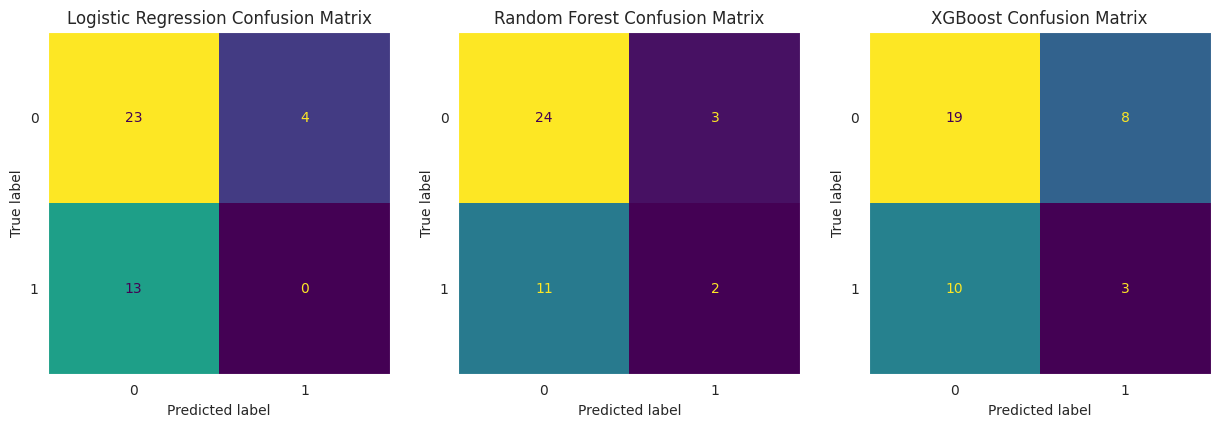


Model Performance Metrics:
                 Model   ROC AUC    PR AUC  F1 Score  Precision    Recall  \
0  Logistic Regression  0.467236  0.294554  0.000000   0.000000  0.000000   
1        Random Forest  0.482906  0.411524  0.222222   0.400000  0.153846   
2              XGBoost  0.387464  0.256714  0.250000   0.272727  0.230769   

   Accuracy  
0     0.575  
1     0.650  
2     0.550  


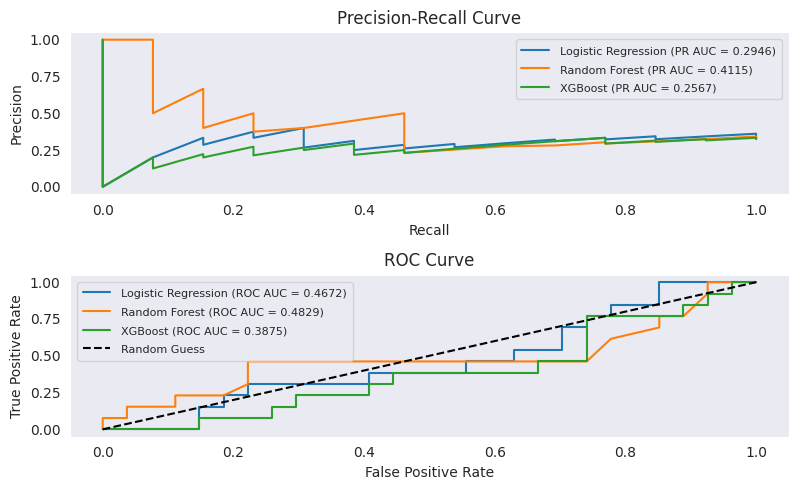

In [26]:
X_train, X_test, y_train, y_test = split_dataset(X, y, random_state=0)

models = {
    "Logistic Regression": get_lr_model(),
    "Random Forest": get_rf_model(),
    "XGBoost": get_xgb_model(),
}

get_metrics_and_plots(models, X_train, X_test, y_train, y_test)

We can see the ROC AUC and F1-score being quite poor.

We will run the same process again with a different split for training and testing sets.

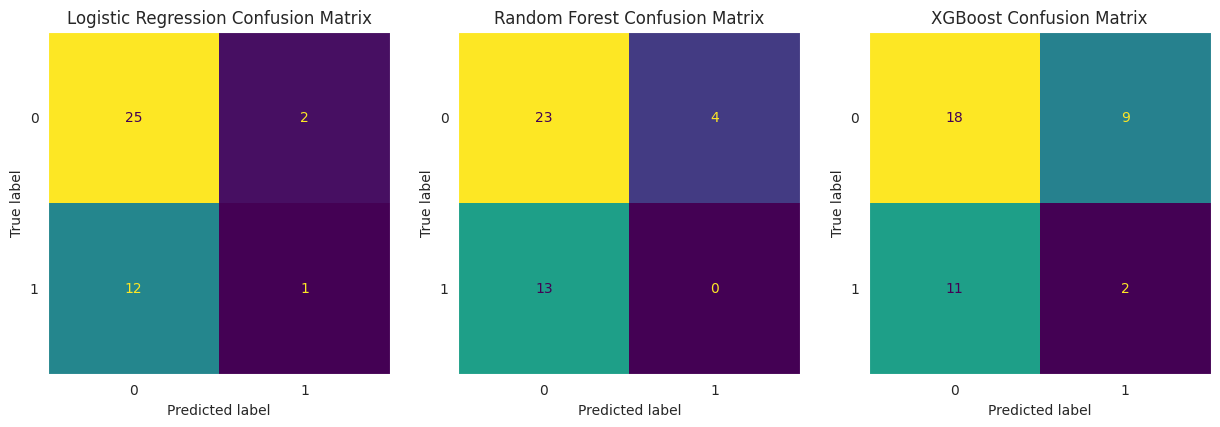


Model Performance Metrics:
                 Model   ROC AUC    PR AUC  F1 Score  Precision    Recall  \
0  Logistic Regression  0.609687  0.355591  0.125000   0.333333  0.076923   
1        Random Forest  0.514245  0.311091  0.000000   0.000000  0.000000   
2              XGBoost  0.558405  0.339363  0.166667   0.181818  0.153846   

   Accuracy  
0     0.650  
1     0.575  
2     0.500  


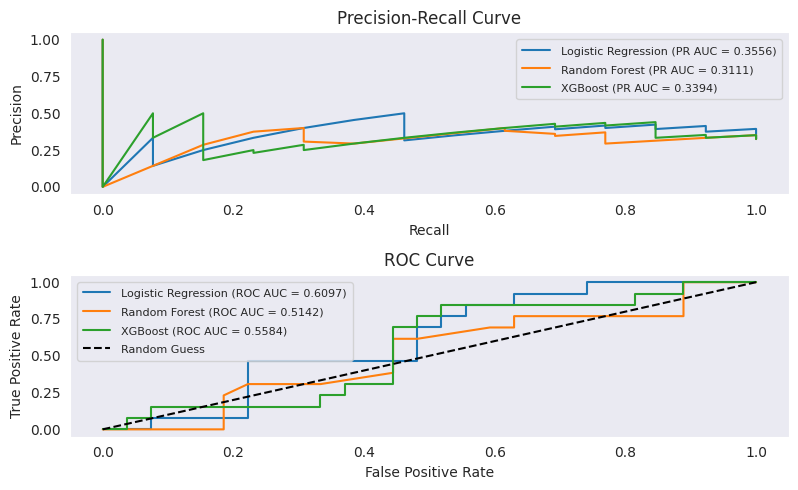

In [27]:
X_train, X_test, y_train, y_test = split_dataset(X, y, random_state=10)

models = {
    "Logistic Regression": get_lr_model(),
    "Random Forest": get_rf_model(),
    "XGBoost": get_xgb_model(),
}

get_metrics_and_plots(models, X_train, X_test, y_train, y_test)

With a different split, we get different results, with ROC AUC being higher for each model, the best being the logistic regression model here.

Something else to explore, as the dataset is quite small, is to not split the dataset into training and testing but to perform cross validation, particularly stratified repeated k-fold cross validation.

Let's just have a look at model interpretability.

Let's keep the random forest model as an example and retrain on the entire dataset. Then, we will use SHAP to get the importance of the features used to train the model.

In [28]:
rf_model = get_rf_model()
rf_model.fit(X, y)

rf_clf = rf_model.named_steps["clf"]

In [29]:
X_transformed = rf_model.named_steps["preprocessor"].transform(X)
X_transformed_df = pd.DataFrame(
    X_transformed, columns=rf_model.named_steps["preprocessor"].get_feature_names_out()
)

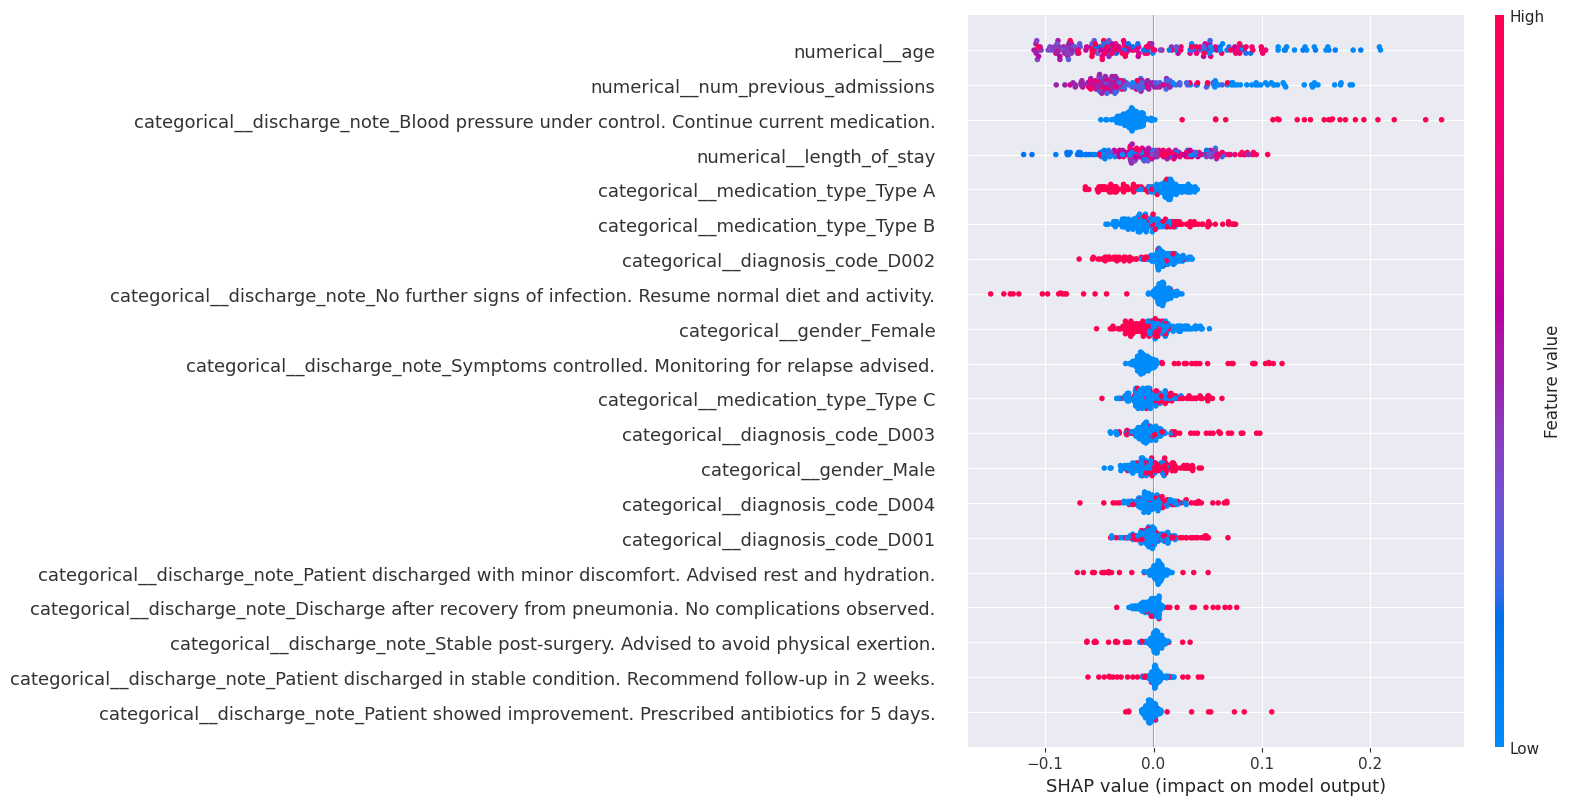

In [30]:
explainer = shap.TreeExplainer(rf_clf)
shap_values = explainer.shap_values(X_transformed_df)
shap.summary_plot(shap_values[:, :, 1], X_transformed_df)

- Features are ranked from most to least important, with age, num_previous_admissions, having a note about the blood pressure, length_of_stay, D003 diagnosis code, gender male and medication type C being the top ones.
- High age shows less readmissions and lower age shows more.
- The model caught the fact that less previous admissions lead to more readmissions.
- We can also notice the model predicts that many patients with a diagnosis code D003 would be readmitted, that many patients with medication type B or type C would be readmitted but less with type A, and patients with blood pressure issues would be readmitted as well.

We need to keep in mind, though, that this model was trained on the entire dataset without any tuning so it doesn't mean it is a good model.

### Potential improvements

Other aspects to explore and experiment with:
- use SMOTE to synthetically generate more rows from the minority class.
- use repeated stratified k-fold cross validation to handle the variability of the dataset, as we saw we can get different results in terms of ROC AUC and other metrics depending on the train/test split of the dataset.
- bin some numerical values together, for example considering 0 previous admissions, then 1, 2 and then 3+.
- extract words and their meanings to get more predictive power.
- gather more data, in terms of patients but also in terms of features.

# Named Entity Recognition from Discharge Notes (LLM/NLP)

For this task, there are a few options to consider:
- use an existing specialized model but this does not seem to be what the task is about.
- annotate notes and fine-tune a NER model to extract entities from discharge notes; however, this is a very small dataset.
- find specific words that would indicate some entities, for example finding "follow-up" in the note, or words like discomfort or pain which would indicate symptoms; however again, this is a small dataset so it wouldn't generalize well.
- use a LLM to either perform question answering or generate text using prompt engineering and using the note as context.

Here, we select the last option and use a LLM from Hugging Face, specifically `Qwen/Qwen2.5-1.5B-Instruct`. I have experimented with `google/flan-t5-large` or similar models and was unable to get consistent outputs, either not grasping the task at hand or not generating anything at all in some cases. The model chosen is an instruct model so it will follow instructions better, in terms of content but also regarding the structure we are looking for as output. Also, Qwen models are performing quite well in general.

In [31]:
model_name = "Qwen/Qwen2.5-1.5B-Instruct"

generator = pipeline(
    "text-generation",
    model_name,
    device=device,
)

Device set to use cuda:0


In [32]:
def extract_entities_qwen(note):
    prompt = f"""
Extract the following entities from the text:
- Diagnosis (should include recovery or improvements)
- Treatment (don't include follow-ups or monitoring)
- Any symptoms (include discomfort, pain)
- Medications (no effects)
- Follow-up actions (should include monitoring, type of follow-up, durations)
Treatment and follow-up should be different. Treatment and medications can be similar

Medical note:
\"{note}\"

Return the extracted information as a JSON object with the following keys:
- "diagnosis"
- "treatment"
- "symptoms"
- "medications"
- "follow_up"
The values in the JSON object should only be text extracted from the note.

For any of the fields, if they're not mentioned in the note, leave them as an empty string. 

Result:
"""
    messages = [
        {"role": "user", "content": prompt},
    ]
    messages = generator(messages, max_new_tokens=256)[0][
        "generated_text"
    ]
    json_string = messages[-1]["content"]
    lines = json_string.strip().splitlines()
    json_lines = lines[1:-1]
    clean_json_str = "\n".join(json_lines)
    data_dict = json.loads(clean_json_str)

    return data_dict

In [33]:
ner_notes = {}
for note in df["discharge_note"].unique():
    ner_notes[note] = extract_entities_qwen(note)

In [34]:
for note in ner_notes:
    print(f"Note: {note}")
    print(ner_notes[note], "\n")

Note: Good recovery trajectory. Follow-up scan scheduled next month.
{'diagnosis': 'Good recovery trajectory', 'treatment': '', 'symptoms': '', 'medications': '', 'follow_up': 'Follow-up scan scheduled next month'} 

Note: Stable post-surgery. Advised to avoid physical exertion.
{'diagnosis': 'Stable post-surgery', 'treatment': '', 'symptoms': '', 'medications': '', 'follow_up': 'Avoid physical exertion for stability'} 

Note: Symptoms controlled. Monitoring for relapse advised.
{'diagnosis': '', 'treatment': 'Monitoring for relapse', 'symptoms': 'none specified', 'medications': '', 'follow_up': 'monitoring'} 

Note: Discharge after recovery from pneumonia. No complications observed.
{'diagnosis': 'pneumonia', 'treatment': '', 'symptoms': '', 'medications': '', 'follow_up': ''} 

Note: Patient discharged in stable condition. Recommend follow-up in 2 weeks.
{'diagnosis': '', 'treatment': 'Recommend follow-up in 2 weeks', 'symptoms': '', 'medications': '', 'follow_up': 'Monitor patient f